# 画图：观察攻击模型对噪声的适应性

In [2]:
import pandas as pd
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("stupidtree/[EXP]BiSR_diff_noise_dc")

summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

In [3]:
filtered = []

for summary, config, name in zip(summary_list, config_list, name_list):
    if config['dataset'] == 'piqa':
        filtered.append((summary, config, name))
sfl_noise_scales = set()

for summary, config, name in filtered:
    sfl_noise_scales.add(str(config['noise_beta_dc']))

In [4]:
# sfl_noise_scales.remove('128')

In [5]:
result_map = {}
for sfl_noise_scale in sfl_noise_scales:
    if sfl_noise_scale == 0.05:
        continue
    attack_performs = {}
    ppl_avg = 0
    tag_avg = 0
    case_num = 0
    for summary, config, name in filtered:
        if str(config['noise_beta_dc']) == str(sfl_noise_scale):
            model_name = config['attacker_model']
            if model_name == 'gru':
                model_name = 'GRU'
            elif model_name == 'moe':
                model_name = 'NaMoE'
            attack_performs[f'SDRP-only({model_name})'] = summary['client0_DRA_b2tr_rgLf_avg']
            attack_performs[f'BiSR({model_name})'] = summary['client0_DLG_rgL_f_avg']
            ppl_avg += summary['client0_test-ppl']
            tag_avg += summary['client0_DLG_raw_rgLf_avg']
            case_num += 1
    attack_performs['PPL'] = ppl_avg / case_num
    attack_performs['TAG'] = tag_avg / case_num
    result_map[sfl_noise_scale] = attack_performs

In [6]:
# rearrange the result

all_data = {}
for key in list(result_map.values())[0].keys():
    all_data[key] = {}
    for sfl_noise_scale, attack_performs in result_map.items():
        all_data[key][sfl_noise_scale] = attack_performs[key]


/tmp/ipykernel_400694/960026938.py:93: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles2, labels2 = ax2.get_legend_handles_labels()


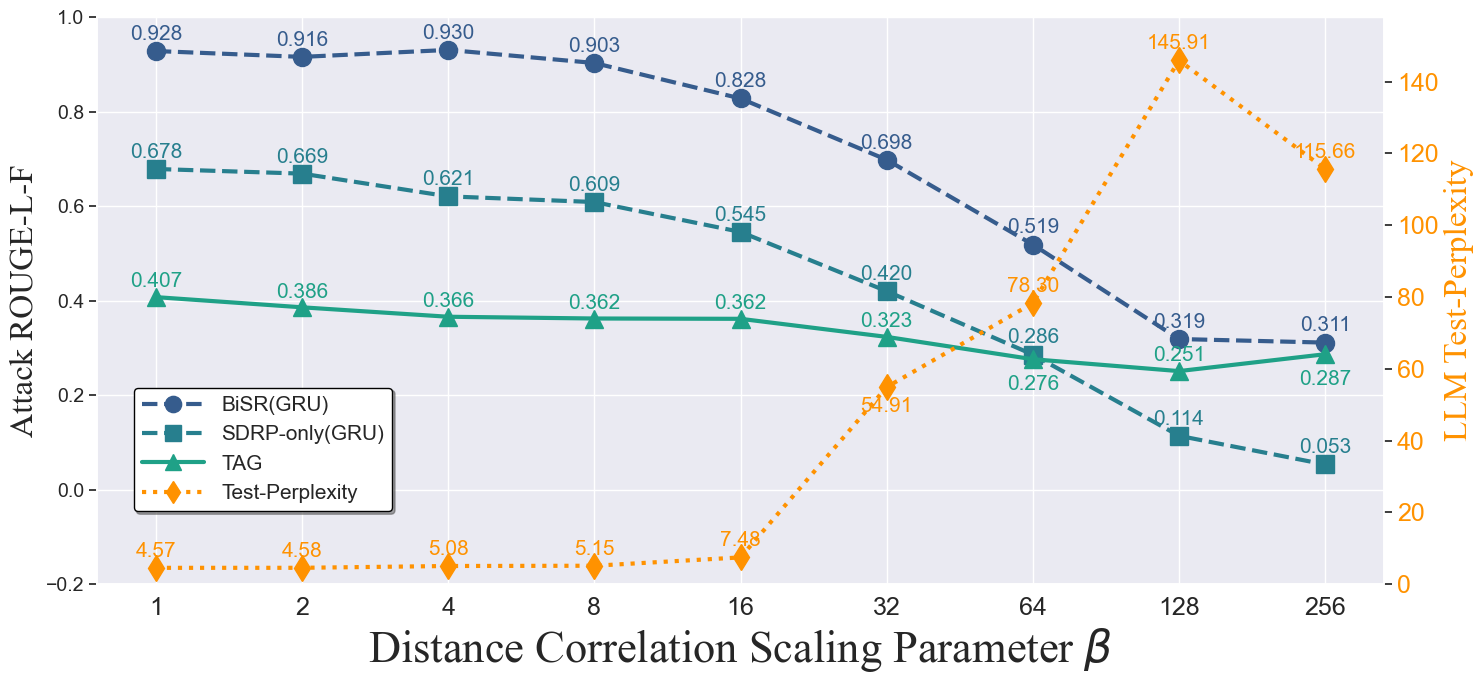

In [17]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set()

# create line figure with two y axis, one for ppl and one for rouge
fig, ax1 = plt.subplots(figsize=(15, 7))
# plot rouge

ax2 = ax1.twinx()
all_data = dict(sorted(all_data.items(), key=lambda x: x[0]))

atk_colors = sns.color_palette("viridis", 6)[1:]
color_ppl = sns.color_palette("autumn", 6)[3]
for key, attack_performs in all_data.items():
    ns = sorted(attack_performs.keys(),key=lambda x:float(x))
    ps = [attack_performs[n] for n in ns]
    if key == 'PPL':
        ax2.plot(ns, ps, markersize=13, color=color_ppl, marker='d', linestyle=':', label='Test-Perplexity',linewidth=3)
        # plit text on top of the line
        for n, txt in zip(ns,ps):
            pos = 8
            if n == '32':# or n =='64':
                pos = -18
            ax2.annotate(f'{txt:.2f}', (n,txt), textcoords="offset points", xytext=(0, pos),
                         ha='center', fontsize=15, color=color_ppl, label='Test-Perplexity')
    else:
        marker = 'o'
        color = atk_colors[0]
        if 'SDRP' in key:
            marker = 's'
            color = atk_colors[1]
        elif 'TAG' in key:
            marker = '^'
            color = atk_colors[2]
        if 'GRU' in key:
            line_style = '--'
        else:
            line_style = '-'
        ax1.plot(ns, ps, marker=marker, markersize=13, label=key, color=color, linestyle=line_style,linewidth=3)
        if key == 'BiSR(NaMoE)':
            # plot text on top of the line
            for n, txt in zip(ns,ps):
                pos = 8
                if n >= 1.25:
                    pos = -18
                elif n == 0.3:
                    pos = 19
                ax1.annotate(f'{txt:.3f}*', (n, txt), textcoords="offset points", xytext=(0, pos),
                             ha='center', fontsize=15, color=color)
        elif key =='BiSR(GRU)':
            # plot text on top of the line
            for n, txt in zip(ns,ps):
                pos = 8
                if  n == 1:
                    pos = -22
                ax1.annotate(f'{txt:.3f}', (n, txt), textcoords="offset points", xytext=(0, pos),
                             ha='center', fontsize=15, color=color)
        elif key == 'TAG':
            for n,txt in zip(ns,ps):
                pos = 7
                if n == '64' or n == '256':
                    pos = -22
                ax1.annotate(f'{txt:.3f}', (n, txt), textcoords="offset points", xytext=(0, pos),
                             ha='center', fontsize=15, color=color)
        elif key == 'SDRP-only(GRU)':
            # plot text on top of the line
            for i, txt in enumerate(ps):
                pos =  8
                ax1.annotate(f'{txt:.3f}', (list(ns)[i], list(ps)[i]), textcoords="offset points", xytext=(0, pos),
                             ha='center', fontsize=15, color=color)
        elif key == 'SDRP-only(NaMoE)':
            # plot text on top of the line
            for i, txt in enumerate(ps):
                pos = -18 if i < 2 else 7
                ax1.annotate(f'{txt:.3f}*', (list(ns)[i], list(ps)[i]), textcoords="offset points", xytext=(0, pos),
                             ha='center', fontsize=15, color=color)

ax1.tick_params(axis='y', labelsize=14)
ax1.set_ylim(-0.2, 1.0)

color = 'tab:blue'
ax1.set_ylabel('Attack ROUGE-L-F', fontsize=24,fontname='Times New Roman')
ax1.set_xlabel('Distance Correlation Scaling Parameter $\\beta$', fontsize=32,fontname='Times New Roman')
ax1.tick_params(axis='x', labelsize=18)
ax2.set_ylabel('LLM Test-Perplexity', fontsize=24,fontname='Times New Roman', color=color_ppl)
ax2.tick_params(axis='y', labelcolor=color_ppl, labelsize=18)
ax2.yaxis.grid(False)
# plt.xticks(sfl_noise_scales, [str(x) for x in sfl_noise_scales])
ax2.set_ylim(0, 158)
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles.extend(handles2)
labels.extend(labels2)

# plt.legend(handles, labels, fontsize=12, ncol=1, loc='lower left', bbox_to_anchor=(0.02, 0.11),
#            markerscale=0.9, handlelength=3.0)

plt.legend(handles, labels, fontsize=15, ncol=1, loc='lower left', bbox_to_anchor=(0.02, 0.11),
           markerscale=0.9, handlelength=3.0, frameon=True, fancybox=True, shadow=True, framealpha=1, edgecolor='black',
           facecolor='white')

# reverse the x axis
# plt.gca().invert_xaxis()
# save the figure
plt.tight_layout()
plt.savefig('/root/autodl-tmp/sfl/exp_data/diff_noise_dc.pdf')